# Initial Experimentation
### The oldest notebook of the repo. Contents are outdated. Served for initial exploration, experimentation and development of functiol.
It is not part of the functional sollution.

### Module Imports

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from scipy.optimize import minimize


plt.rcParams["figure.figsize"] = [8, 6]

### Constants

In [2]:
##TODO: Make interactive/export to config
start_date = "2021-01-01"
today_date = "2022-10-24"
end_date = "2024-10-25"

tickers = ["COST", "ANSS", "ZS", "ADSK", "SIRI", "TXN", "PCAR", "EXC"]  ##OG Tickers
# tickers = ["AAPL", "MSFT", "NVDA", "TSLA", "JNJ", "PEP", "INTC", "WMT"] ##Alternative testing ticker
initial_capital = 100000

num_days_buisness_year = 252

Assume, that you are a consultant of an investor on NASDAQ stock exchange, whose initial capital is
100 000 USD. He is allowed to invest into the following eight stocks – (see enclosed paper with list of
stocks) and potentially into the risk-free asset, one-month treasury bond of the US government. The
investor is asking for an advice how to invest his capital.

In [3]:
data = yf.download(tickers, start=start_date, end=end_date, interval="1d")

[*********************100%***********************]  8 of 8 completed


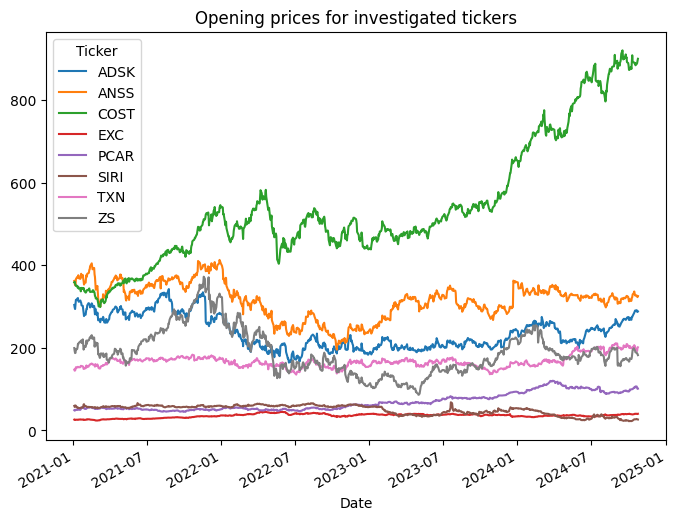

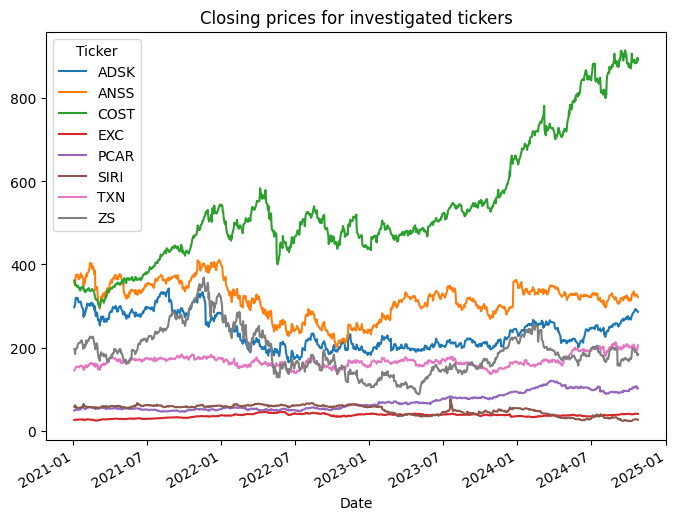

In [4]:
data.Open.plot()
plt.title("Opening prices for investigated tickers")
plt.show()

data.Close.plot()
plt.title("Closing prices for investigated tickers")
plt.show()

In [5]:
data_open = data.Open.copy()
data_open.rename(
    columns={f"{col}": f"{col}_open" for col in data_open.columns}, inplace=True
)
data_close = data.Close.copy()
data_close.rename(
    columns={f"{col}": f"{col}_close" for col in data_close.columns}, inplace=True
)

data_joined = data_open.join(data_close)

In [6]:
print(data_joined.head())

Ticker       ADSK_open   ANSS_open   COST_open   EXC_open  PCAR_open  \
Date                                                                   
2021-01-04  304.109985  362.350006  358.978372  26.268336  49.190395   
2021-01-05  297.839996  356.779999  360.338499  25.519054  48.111276   
2021-01-06  294.149994  351.850006  355.544878  25.636707  48.684902   
2021-01-07  305.450012  352.609985  352.872253  26.286913  49.860573   
2021-01-08  316.410004  366.559998  350.123461  26.014444  50.360370   

Ticker      SIRI_open    TXN_open     ZS_open  ADSK_close  ANSS_close  \
Date                                                                    
2021-01-04  59.596254  147.435854  199.720001  296.839996  357.670013   
2021-01-05  57.078098  144.838274  192.369995  301.700012  359.829987   
2021-01-06  58.197274  145.375735  187.529999  302.869995  349.899994   
2021-01-07  60.622163  148.089746  188.095001  315.200012  365.019989   
2021-01-08  59.596246  153.275977  196.750000  319.850006

In [7]:
##Missing values
print(data_joined.isna().sum())

Ticker
ADSK_open     0
ANSS_open     0
COST_open     0
EXC_open      0
PCAR_open     0
SIRI_open     0
TXN_open      0
ZS_open       0
ADSK_close    0
ANSS_close    0
COST_close    0
EXC_close     0
PCAR_close    0
SIRI_close    0
TXN_close     0
ZS_close      0
dtype: int64


In [8]:
##Zero values
print((data_joined == 0).sum())

Ticker
ADSK_open     0
ANSS_open     0
COST_open     0
EXC_open      0
PCAR_open     0
SIRI_open     0
TXN_open      0
ZS_open       0
ADSK_close    0
ANSS_close    0
COST_close    0
EXC_close     0
PCAR_close    0
SIRI_close    0
TXN_close     0
ZS_close      0
dtype: int64


### Calculate daily returns

In [9]:
for ticker in tickers:
    data_joined[f"{ticker}_ratio"] = (
        data_joined[f"{ticker}_close"] / data_joined[f"{ticker}_open"]
    )
    data_joined[f"{ticker}_log_ratio"] = np.log(data_joined[f"{ticker}_ratio"])

In [10]:
log_ratio_cols = [col for col in data_joined.columns if "_log_ratio" in col]

data_log_ratio = data_joined[log_ratio_cols]

In [11]:
data_log_ratio.describe()

Ticker,COST_log_ratio,ANSS_log_ratio,ZS_log_ratio,ADSK_log_ratio,SIRI_log_ratio,TXN_log_ratio,PCAR_log_ratio,EXC_log_ratio
count,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000
mean,0.000659,-0.000338,-0.000748,0.000072,-0.001313,-0.000022,0.000021,0.000307
std,0.012325,0.017047,0.028646,0.018392,0.026697,0.014226,0.013256,0.012613
min,-0.068838,-0.062205,-0.153652,-0.072678,-0.195061,-0.053501,-0.053820,-0.083972
25%,-0.006113,-0.010315,-0.014503,-0.010272,-0.012883,-0.008761,-0.007973,-0.006396
50%,0.001161,-0.000529,0.001041,0.000668,0.000000,0.000209,0.000306,0.000535
75%,0.007666,0.008980,0.015033,0.010621,0.009646,0.009289,0.007937,0.007598
max,0.056335,0.117479,0.145920,0.068157,0.356126,0.057071,0.060751,0.050121


In [12]:
data_log_ratio.cov()

Ticker,COST_log_ratio,ANSS_log_ratio,ZS_log_ratio,ADSK_log_ratio,SIRI_log_ratio,TXN_log_ratio,PCAR_log_ratio,EXC_log_ratio
Ticker,,,,,,,,
COST_log_ratio,0.000152,0.000107,0.000121,0.000092,0.000056,0.000078,0.000044,0.000044
ANSS_log_ratio,0.000107,0.000291,0.000294,0.000215,0.000074,0.000140,0.000057,0.000040
ZS_log_ratio,0.000121,0.000294,0.000821,0.000322,0.000061,0.000167,0.000063,0.000004
ADSK_log_ratio,0.000092,0.000215,0.000322,0.000338,0.000079,0.000137,0.000068,0.000035
SIRI_log_ratio,0.000056,0.000074,0.000061,0.000079,0.000713,0.000065,0.000047,0.000034
TXN_log_ratio,0.000078,0.000140,0.000167,0.000137,0.000065,0.000202,0.000067,0.000029
PCAR_log_ratio,0.000044,0.000057,0.000063,0.000068,0.000047,0.000067,0.000176,0.000036
EXC_log_ratio,0.000044,0.000040,0.000004,0.000035,0.000034,0.000029,0.000036,0.000159


In [13]:
data_previous = data_log_ratio.loc[:today_date]
data_previous

Ticker,COST_log_ratio,ANSS_log_ratio,ZS_log_ratio,ADSK_log_ratio,SIRI_log_ratio,TXN_log_ratio,PCAR_log_ratio,EXC_log_ratio
Date,,,,,,,,
2021-01-04,0.007181,-0.013000,-0.018343,-0.024196,-0.035035,-0.014565,-0.022064,-0.029910
2021-01-05,-0.008269,0.008512,0.005754,0.012877,0.019418,0.010520,0.008698,-0.002429
2021-01-06,-0.010217,-0.005558,-0.016723,0.029214,0.043894,0.011761,0.035413,0.025046
2021-01-07,-0.008363,0.034590,0.026002,0.031421,-0.012384,0.015663,0.006924,-0.009943
2021-01-08,0.004932,0.021857,0.003146,0.010813,-0.078088,0.000234,-0.009860,0.004750
...,...,...,...,...,...,...,...,...
2022-10-18,0.000148,-0.003405,-0.009375,-0.019637,-0.001604,-0.023354,0.003092,0.000000
2022-10-19,0.007708,0.002899,0.005798,-0.001927,-0.001627,0.013321,0.001434,-0.002169
2022-10-20,-0.013638,-0.019196,0.006344,-0.000657,-0.001638,-0.001105,-0.038421,-0.030482


In [14]:
correlation_matrix = data_log_ratio.corr()
covariance_matrix = data_log_ratio.cov()
means = data_log_ratio.mean()

In [15]:
# np.invert(covariance_matrix)
np.diag(np.linalg.inv(np.array(covariance_matrix)))

np.linalg.cond(
    covariance_matrix
)  ##Matrix condition number is sufficiently small to safely construct inverse matrix

15.982067198871771

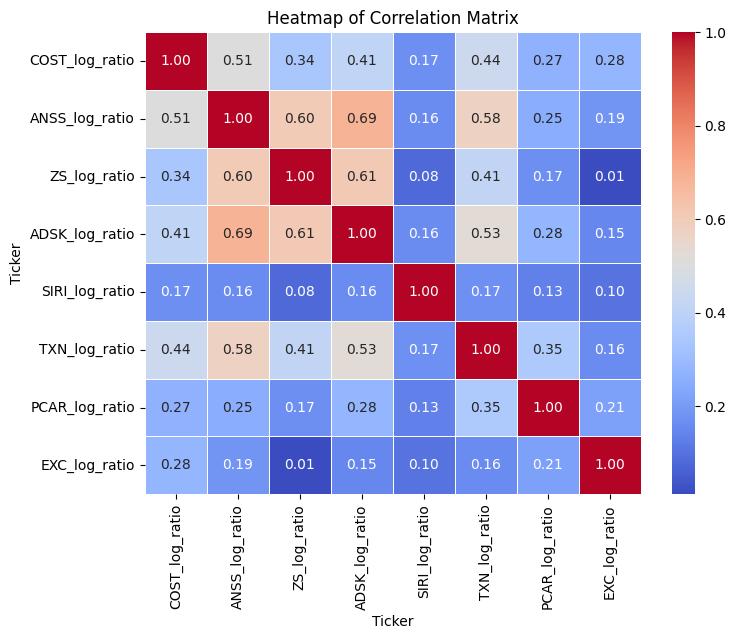

In [16]:
##All our stocks seem to be positively correlated
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Correlation Matrix")
plt.show()

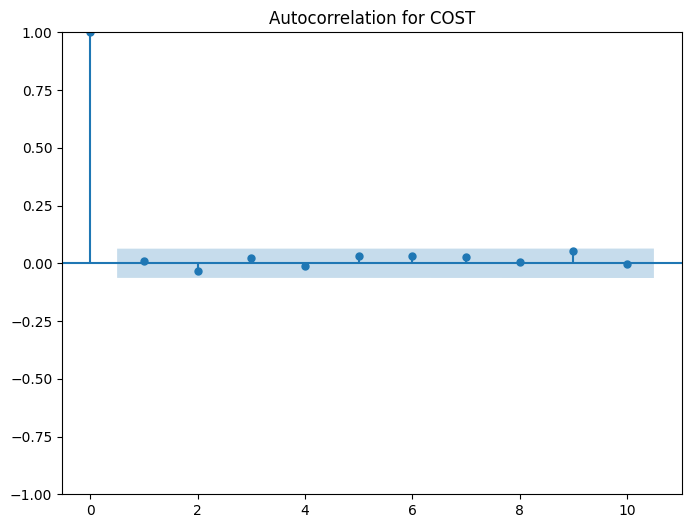

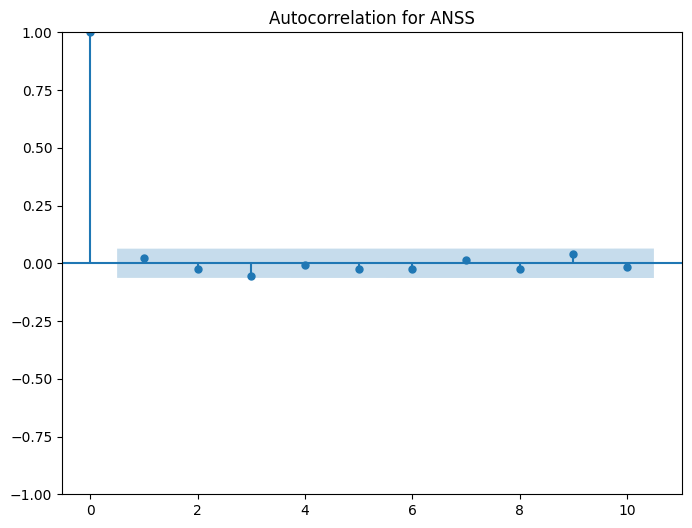

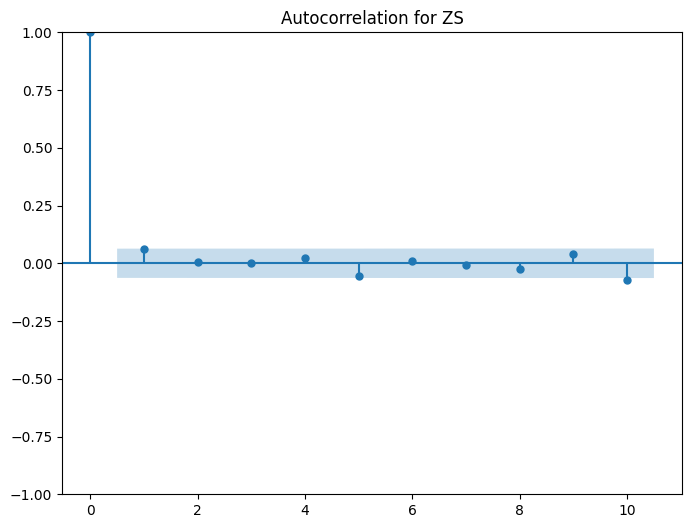

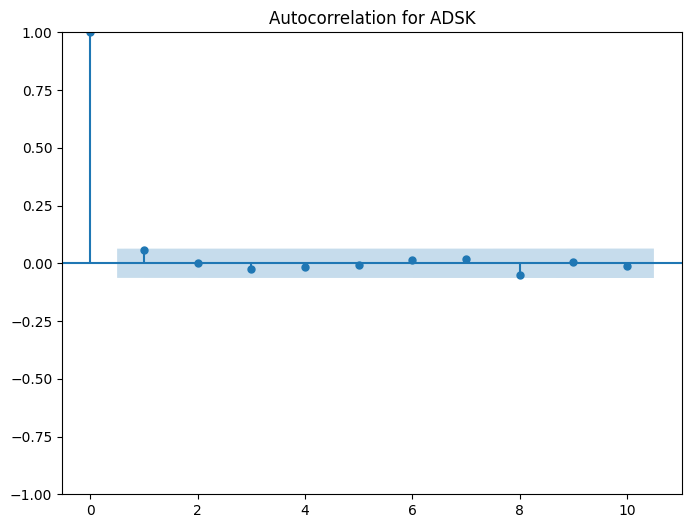

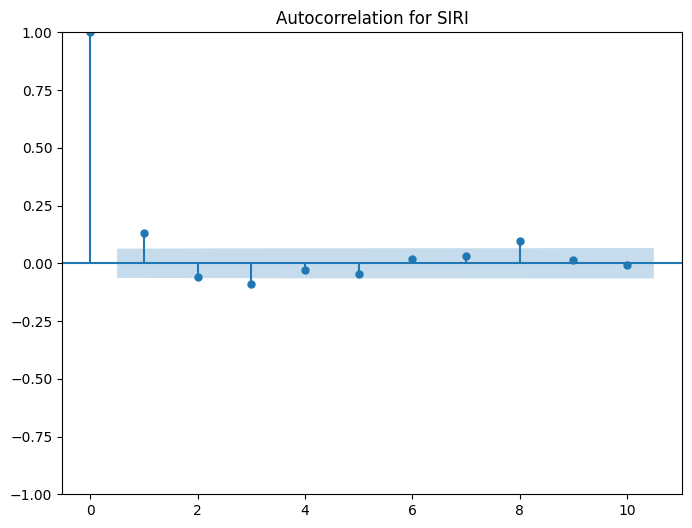

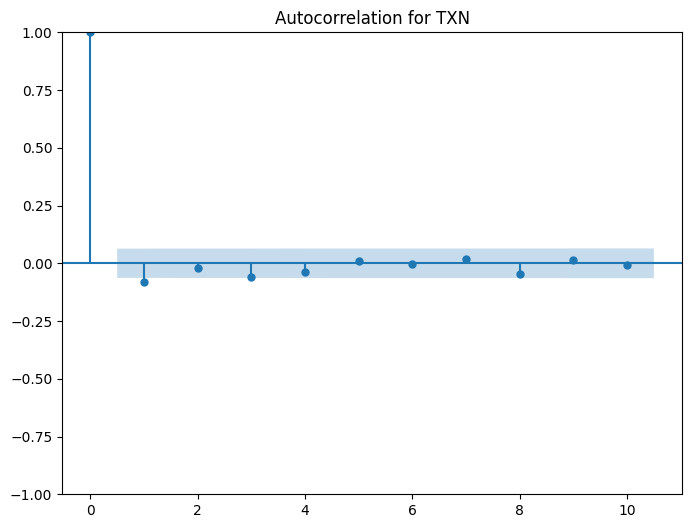

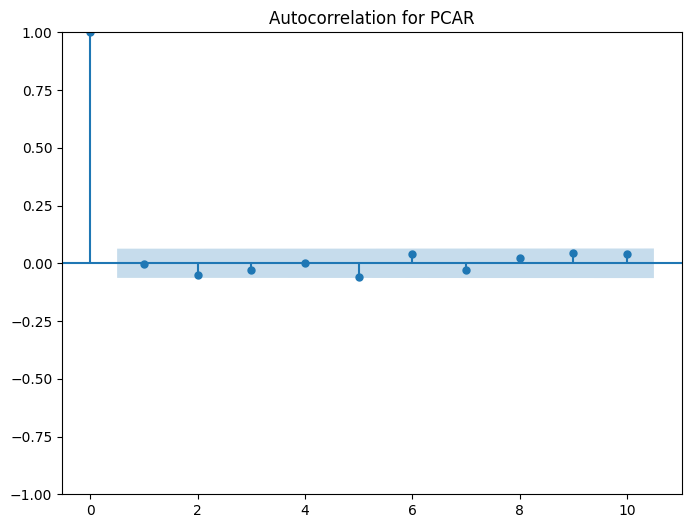

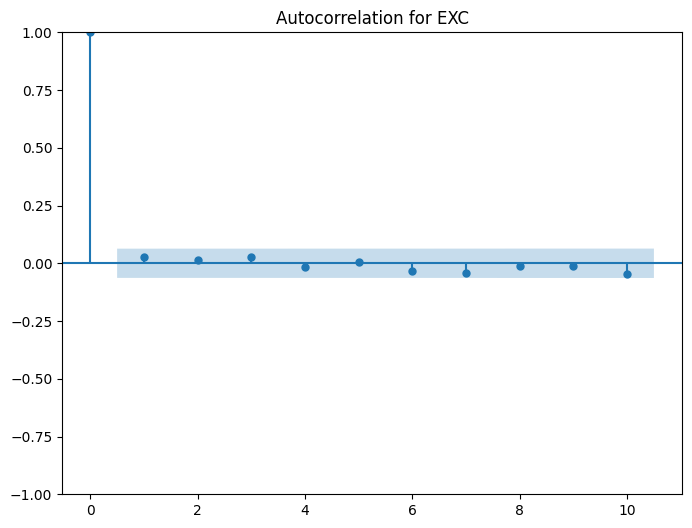

In [17]:
for ticker in tickers:
    plot_acf(
        data_log_ratio[f"{ticker}_log_ratio"],
        lags=10,
        title=f"Autocorrelation for {ticker}",
    )
    plt.show()

In [18]:
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))


def portfolio_std(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

In [19]:
def efficient_frontier(
    mean_returns, cov_matrix, target_returns, min_func=portfolio_variance
):
    num_assets = len(mean_returns)
    results = []
    for target in target_returns:
        constraints = (
            {"type": "eq", "fun": lambda w: np.sum(w) - 1},
            {"type": "eq", "fun": lambda w: np.dot(w, mean_returns) - target},
        )
        # bounds = [(0, 1)] * num_assets  # Weights between 0 and 1
        initial_weights = np.ones(num_assets) / num_assets
        opt_result = minimize(
            min_func,
            initial_weights,
            args=(cov_matrix,),
            method="SLSQP",
            constraints=constraints,
        )
        results.append((target, opt_result.fun))
    return results

In [20]:
train_data = data_log_ratio.loc[start_date:today_date]

train_means = train_data.mean()
train_covariance_matrix = train_data.cov()

print(
    np.linalg.cond(np.array(train_covariance_matrix))
)  ## Reasonably small Matrix cond. number

21.99139736315277


In [21]:
target_returns = np.linspace(train_means.min() * 10, train_means.max() * 20, 300)

efficient_results = efficient_frontier(
    train_means, train_covariance_matrix, target_returns
)

efficient_results_2 = efficient_frontier(
    train_means, train_covariance_matrix, target_returns, min_func=portfolio_std
)

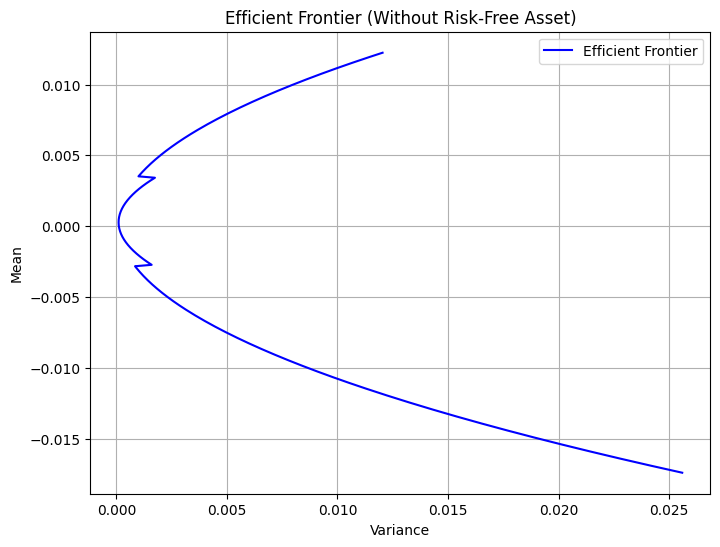

In [22]:
opt_variances, opt_means = zip(*efficient_results)
plt.plot(opt_means, opt_variances, "b-", label="Efficient Frontier")

plt.title("Efficient Frontier (Without Risk-Free Asset)")
plt.xlabel("Variance")
plt.ylabel("Mean")
plt.grid()
plt.legend()
plt.show()

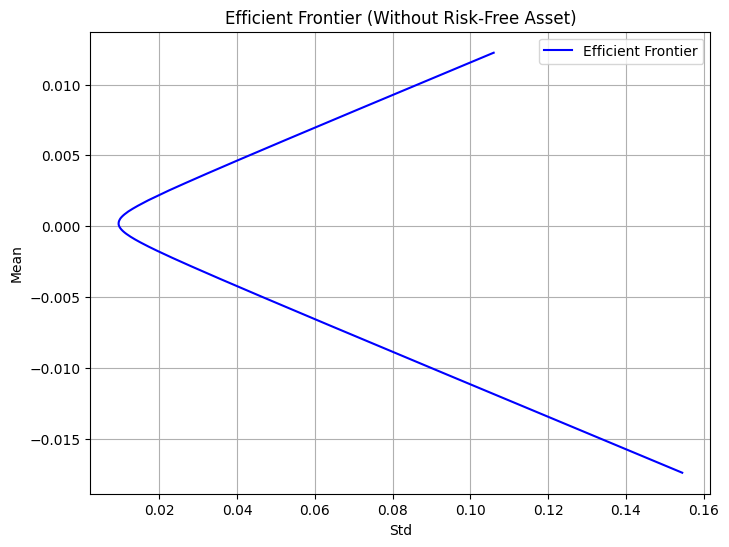

In [23]:
opt_variances, opt_means = zip(*efficient_results_2)
plt.plot(opt_means, opt_variances, "b-", label="Efficient Frontier")

plt.title("Efficient Frontier (Without Risk-Free Asset)")
plt.xlabel("Std")
plt.ylabel("Mean")
plt.grid()
plt.legend()
plt.show()

#### Investigate US treasury yields

In [24]:
yields_data = pd.read_csv("USYields2024.csv")

yields_data["Date"] = pd.to_datetime(yields_data["Date"], format="%d/%m/%Y")

yields_data.set_index("Date", inplace=True)

Convert the yearly rates to daily


In [25]:
## Convert the annualized monthly rate to daily
days_in_a_year = 365


yields_data["daily_1_mo"] = (
    yields_data["1 Mo"] / days_in_a_year / 100
)  ##Convert from percentages and convert annual to daily

yields_data["daily_1_mo_log"] = np.log(1 + yields_data["daily_1_mo"])

yields_data["daily_1_mo_log"].mean()

6.473166491495945e-05

In [26]:
train_yields_data = yields_data.loc[start_date:today_date]

mean_riskfree_rate = train_yields_data["daily_1_mo_log"].mean()

today_riskfree_rate = yields_data["daily_1_mo_log"].loc[today_date]

##View the large difference between mean risk-free rate in the test period and today's value
print(
    f"Mean riskree rate: {mean_riskfree_rate}, Today riskfree rate: {today_riskfree_rate}"
)

Mean riskree rate: 1.5020387103903611e-05, Today riskfree rate: 9.780343626604175e-05


In [27]:
train_yields_data

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,daily_1_mo,daily_1_mo_log
Date,,,,,,,,,,,,,,
2021-01-04,0.09,0.09,0.09,0.09,0.10,0.11,0.16,0.36,0.64,0.93,1.46,1.66,0.000002,0.000002
2021-01-05,0.08,0.09,0.09,0.09,0.10,0.13,0.17,0.38,0.66,0.96,1.49,1.70,0.000002,0.000002
2021-01-06,0.09,0.09,0.09,0.09,0.11,0.14,0.20,0.43,0.74,1.04,1.60,1.81,0.000002,0.000002
2021-01-07,0.09,0.09,0.09,0.09,0.11,0.14,0.22,0.46,0.78,1.08,1.64,1.85,0.000002,0.000002
2021-01-08,0.08,0.08,0.08,0.09,0.10,0.14,0.24,0.49,0.81,1.13,1.67,1.87,0.000002,0.000002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-18,3.25,3.70,4.04,4.39,4.50,4.43,4.43,4.21,4.12,4.01,4.27,4.04,0.000089,0.000089
2022-10-19,3.31,3.72,4.07,4.45,4.60,4.55,4.56,4.35,4.26,4.14,4.38,4.15,0.000091,0.000091
2022-10-20,3.58,3.83,4.09,4.48,4.66,4.62,4.66,4.45,4.36,4.24,4.47,4.24,0.000098,0.000098


#### Capital Market line

In [28]:
##Calculate tangent portfolio

inv_cov = np.linalg.inv(np.array(train_covariance_matrix))
train_means = np.array(train_means)
unit_vec = np.ones_like(train_means)

A = unit_vec.T @ (inv_cov @ unit_vec)
B = unit_vec.T @ (inv_cov @ train_means)
C = train_means.T @ (inv_cov @ train_means)

mu_0 = today_riskfree_rate
# mu_0 = mean_riskfree_rate

In [29]:
print(f"{A = }")
print(f"{B = }")
print(f"{C = }")

A = 11128.254626204438
B = 2.2405081981858985
C = 0.013489964970642929


In [30]:
weights_tangent = (inv_cov @ (train_means - (unit_vec * mu_0))) / (B - mu_0 * A)

mu_tangent = np.dot(train_means, weights_tangent)

variance_tangent = weights_tangent.T @ (train_covariance_matrix @ weights_tangent)

In [31]:
print(weights_tangent)
print(mu_tangent)
print(variance_tangent)

print(portfolio_variance(weights_tangent, train_covariance_matrix))

[ 5.48463275 -4.7131695  -1.37177874  1.62443535 -0.45891121  2.24604417
 -3.6495398   1.83828698]
0.011518556141045081
0.009912757980483218
0.009912757980483218


C:\Users\stepa\AppData\Local\Temp\ipykernel_17524\4023358980.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.scatter([stock_stds[i]], [means[i]], color="green", zorder=3)
C:\Users\stepa\AppData\Local\Temp\ipykernel_17524\4023358980.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(stock_stds[i], means[i], ticker, fontsize=9, ha="center", va="bottom")


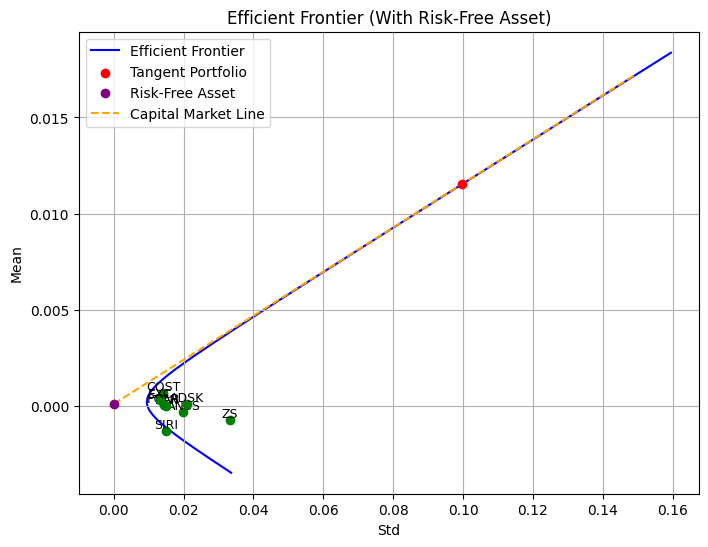

In [32]:
target_returns = np.linspace(train_means.min() * 2, train_means.max() * 30, 300)
efficient_results = efficient_frontier(
    train_means, train_covariance_matrix, target_returns, portfolio_std
)

opt_stds, opt_means = zip(*efficient_results)

##Efficient frontier
plt.plot(opt_means, opt_stds, "b-", label="Efficient Frontier", zorder=1)

##Tangent portfolio
plt.scatter(
    [np.sqrt(variance_tangent)],
    [mu_tangent],
    color="red",
    label="Tangent Portfolio",
    zorder=3,
)

##Individual stocks
stock_stds = np.sqrt(np.diag(train_covariance_matrix))
for i, ticker in enumerate(tickers):
    plt.scatter([stock_stds[i]], [means[i]], color="green", zorder=3)
    plt.text(stock_stds[i], means[i], ticker, fontsize=9, ha="center", va="bottom")

##Risk-free asset
plt.scatter(0, mu_0, color="purple", label="Risk-Free Asset", zorder=3)

##Capital Market line
cml_x = np.linspace(0, np.sqrt(variance_tangent) * 1.5, 500)
cml_y = mu_0 + (cml_x / np.sqrt(variance_tangent)) * (mu_tangent - mu_0)
plt.plot(
    cml_x, cml_y, color="orange", linestyle="--", label="Capital Market Line", zorder=2
)

plt.title("Efficient Frontier (With Risk-Free Asset)")
plt.xlabel("Std")
plt.ylabel("Mean")
plt.grid()
plt.xlim(left=-0.01)
plt.legend()
plt.show()

### Security Market Line

In [33]:
## TODO: Implement securtiy market line

## Markowitz model

In [34]:
def cal_means(data):
    return data.mean()


def cal_cov_matrix(data):
    return data.cov()


def get_daily_params(data, mean_coef=0.8):
    means = cal_means(data)
    cov_matrix = cal_cov_matrix(data)
    required_return = mean_coef * means.max()  ##Required
    return means, cov_matrix, required_return


def compute_markowitz_weights(means, cov_matrix, riskfree_return, required_return):
    inv_cov = np.linalg.inv(
        np.array(cov_matrix)
    )  ##TODO: Incorporate warnings for high cond. number of the matrix
    means = np.array(means)
    unit_vec = np.ones_like(means)

    A = unit_vec.T @ (inv_cov @ unit_vec)
    B = unit_vec.T @ (inv_cov @ train_means)
    C = train_means.T @ (inv_cov @ train_means)

    nominator = (required_return - riskfree_return) * (
        inv_cov @ (means - (riskfree_return * means))
    )
    denominator = C - (2 * B * riskfree_return) + (A * (riskfree_return**2))

    shares_weights = nominator / denominator

    riskfree_asset_weight = 1 - np.dot(shares_weights, unit_vec)

    return shares_weights, riskfree_asset_weight


def periodical_gain_for_portfolio(
    portfolio_value,
    shares_weights,
    riskfree_asset_weight,
    periodical_share_returns,
    periodical_riskfree_return,
):
    shares_capital = shares_weights * portfolio_value
    riskfree_capital = riskfree_asset_weight * portfolio_value

    ##Returns are expcted to be in raw multiplicative form (exclude other forms or implement appropriate conversion)
    shares_capital_incremented = shares_capital * periodical_share_returns
    riskfree_capital_incremented = riskfree_capital * periodical_riskfree_return

    incremented_portfolio_value = (
        np.sum(shares_capital_incremented) + riskfree_capital_incremented
    )

    return incremented_portfolio_value


def single_daily_reinvesting_strategy(
    initial_portfolio_value,
    full_data_stocks,
    full_data_riskfree,
    today_date,
    start_est_date,
    riskfree_rate_col="daily_1_mo_log",
    mean_coef=0.8,
):
    """
    For a single day:
        - Aquire data available, compute statistics
        - Compute the daily portfolio
        - Trade according to the used portfolio
    """

    today_riskfree_return = full_data_riskfree[riskfree_rate_col].loc[today_date]

    today_shares_available_data = full_data_stocks.loc[
        start_est_date:today_date
    ]  ##TODO: Use only data up to today (excluding today's date)
    today_share_means, today_share_cov, today_required_return = get_daily_params(
        today_shares_available_data, mean_coef=mean_coef
    )

    today_share_weights, today_riskfree_weight = compute_markowitz_weights(
        today_share_means, today_share_cov, today_riskfree_return, today_required_return
    )

    ##TODO: Implement correct data preparation functions, include raw share returns
    incremented_portfolio_value = periodical_gain_for_portfolio(
        initial_portfolio_value,
        today_share_weights,
        today_riskfree_weight,
        today_share_returns,
        today_riskfree_return,
    )

    return incremented_portfolio_value, today_share_weights, today_riskfree_weight


##TODO: Generalize following function to allow for additional portfolio strategies (not just markowitz)
def multiple_daily_reinvesting_strategy(
    initial_portfolio_value,
    full_data_stocks,
    full_data_riskfree,
    start_est_date: str,
    start_trade_date: str,
    end_trade_date: str,
    mean_coef=0.8,
):
    start_trade_date = pd.Timestamp(start_trade_date)
    end_trade_date = pd.Timestamp(end_trade_date)

    portfolio_value = initial_portfolio_value
    daily_portfolio_values = []  # Daily portfolio values
    daily_portfolio_share_weights = []
    daily_portfolio_riskfree_weights = []
    realized_trade_dates = []
    potential_investment_dates = pd.date_range(
        start=start_trade_date, end=end_trade_date
    )

    for today_date in potential_investment_dates:
        if today_date in full_data_stocks.index:
            realized_trade_dates.append(today_date)

            portfolio_value, today_share_weights, today_riskfree_weight = (
                single_daily_reinvesting_strategy(
                    portfolio_value,
                    full_data_stocks,
                    full_data_riskfree,
                    today_date,
                    start_est_date,
                    mean_coef=mean_coef,
                )
            )

            daily_portfolio_values.append(portfolio_value)
            daily_portfolio_share_weights.append(today_share_weights)
            daily_portfolio_riskfree_weights.append(today_riskfree_weight)

    return (
        daily_portfolio_values,
        daily_portfolio_share_weights,
        daily_portfolio_riskfree_weights,
        realized_trade_dates,
    )


##TODO Implement reinvesting via fixed strategy